<a href="https://colab.research.google.com/github/zisserj/PBP/tree/main/BP_to_BN" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pgmpy -q

In [2]:
from collections import defaultdict
import itertools
import graphviz
import numpy as np
import pandas as pd

#Monty Hall pgmpy (direct)


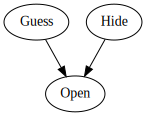

In [3]:
dot = graphviz.Digraph(comment='#Monty Hall pgmpy')

dot.node('G', 'Guess')
dot.node('H', 'Hide')
dot.node('O', 'Open')

dot.edges(['GO', 'HO'])
dot

In [4]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Defining the network structure
model = BayesianNetwork([("G", "O"), ("H", "O")])

# Defining the CPDs:
cpd_g = TabularCPD("G", 3, [[0.33], [0.33], [0.33]])
cpd_h = TabularCPD("H", 3, [[0.33], [0.33], [0.33]])
cpd_o = TabularCPD(
    "O",
    3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],
    ],
    evidence=["G", "H"],
    evidence_card=[3, 3],
)

# Associating the CPDs with the network structure.
model.add_cpds(cpd_g, cpd_h, cpd_o)

# Some other methods
model.get_cpds()

[<TabularCPD representing P(G:3) at 0x7effffc7a9b0>,
 <TabularCPD representing P(H:3) at 0x7effffc7a8f0>,
 <TabularCPD representing P(O:3 | G:3, H:3) at 0x7effffc7b460>]

In [5]:
# check_model check for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception
model.check_model()

True

In [6]:
model.get_cpds()

[<TabularCPD representing P(G:3) at 0x7effffc7a9b0>,
 <TabularCPD representing P(H:3) at 0x7effffc7a8f0>,
 <TabularCPD representing P(O:3 | G:3, H:3) at 0x7effffc7b460>]

In [7]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_h = infer.query(["H"], evidence={"G": 0, "O": 2})
print(posterior_h)

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.3333 |
+------+----------+
| H(1) |   0.6667 |
+------+----------+
| H(2) |   0.0000 |
+------+----------+


#BThreds implementation


###B-threads definition

In [93]:
N_DOORS = 4
DOORS = range(1, N_DOORS+1)

BTHREADS= ['bt1','bt2','bt3']

INITIALS={'bt1':'0', 'bt2':'0', 'bt3':'0'}


EVENTS = ['default'] + [f'g{n}' for n in DOORS] + [f'h{n}' for n in DOORS] + [f'o{n}' for n in DOORS]

STATES = {'bt1': ['0', '1', '2', '3'],
          'bt2': [str(n) for n in range(N_DOORS+1)],
          'bt3': [str(n) for n in range(N_DOORS+1)]}

BLOCKED = defaultdict(list,{})

REQUESTED = defaultdict(list,
            {'bt1_state_0': [f'h{n}' for n in DOORS],
             'bt1_state_1': [f'g{n}' for n in DOORS],
             'bt1_state_2': [f'o{n}' for n in DOORS]})

TIME = range(4)

TRANSITIONS = set()

for n in DOORS:
    BLOCKED[f'bt2_state_{n}'] += [f'o{n}']
    BLOCKED[f'bt3_state_{n}'] += [f'o{n}']


    TRANSITIONS |= {('bt1_state_0', 'bt1_state_1', f'h{n}'),
                    ('bt1_state_1', 'bt1_state_2', f'g{n}'),
                    ('bt1_state_2', 'bt1_state_3', f'o{n}'),
                    ('bt2_state_0', f'bt2_state_{n}', f'h{n}'),
                    ('bt3_state_0', f'bt3_state_{n}', f'g{n}')}

# Translation to Bayesian Network

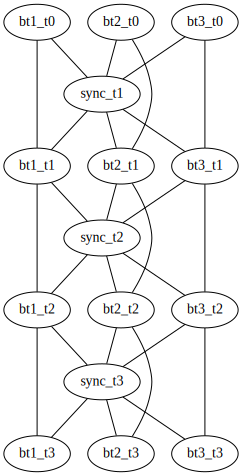

In [67]:
p = graphviz.Graph(name='Bayesian Network via BP')

for bt in BTHREADS:
  for t in TIME[1:]:
    p.edge(f'{bt}_t{t-1}', f'sync_t{t}')
    p.edge(f'sync_t{t}', f'{bt}_t{t}')
    p.edge(f'{bt}_t{t-1}', f'{bt}_t{t}')
p

##BP util functions

In [10]:
def requested_not_blocked(row) -> set:
  # get set of all requested not blocked  from given state
  states = [row[bt] for bt in BTHREADS]
  requested = list()
  blocked = list()
  for bt,s in enumerate(states):
    requested.extend(REQUESTED[f'bt{bt+1}_state_{s}'])
    blocked.extend(BLOCKED[f'bt{bt+1}_state_{s}'])
  return set(requested) - set(blocked)

In [11]:
def event_prob(event,rnb_set):
  # calculate event probability 
  # using uniform distribution for all 
  # requested not blocked events
  if event in rnb_set:
    return 1/len(rnb_set)
  elif len(rnb_set) == 0 and event == 'default':
    return 1
  else:  
    return 0

In [12]:
def check_no_transition(bt_name, source, event):
  # checks that there aren't any transition from given state with given event
  for target in STATES[bt_name]:
    if (f"{bt_name}_state_{source}", f"{bt_name}_state_{target}" , event) in TRANSITIONS:
      return False
  return True
check_no_transition('bt1', '0', 'h1')

False

In [13]:
def is_valid_transition(bt_name, source, target, event):
  # check if transition is valid using TRANSITIONS data structure
  # if the transition not exists checks if self loop should be assigend
  if (f"{bt_name}_state_{source}", f"{bt_name}_state_{target}" , event) in TRANSITIONS:
    return 1
  elif source == target and check_no_transition(bt_name, source, event):
    return 1
  else:   
    return 0

##Create CPDs

In [14]:
def pivot_cpd(df):
  pivot_df = pd.pivot_table(df, values='prob', index=['event'],
                    columns=BTHREADS).reset_index()                 
  return pivot_df

def get_cpd_event_table():
  states = [STATES[bt] for bt in BTHREADS]
  states.append(EVENTS)
  event_table = [p for p in itertools.product(*states)]
  columns = BTHREADS +['event']
  df = pd.DataFrame(event_table, columns=columns)
  df['prob'] = df.apply(lambda x: event_prob(x['event'], requested_not_blocked((x))), axis=1)
  df.sort_values(by=columns)
  return pivot_cpd(df)

In [15]:
def get_cpd_table_internal_state(bt_name):
  states = [STATES[bt_name],list(EVENTS), STATES[bt_name]]
  event_table = [p for p in itertools.product(*states)]
  columns = [bt_name , 'event', f'next_{bt_name}']
  df = pd.DataFrame(event_table, columns=columns)
  df['prob'] = df.apply(lambda x: is_valid_transition(bt_name, x[bt_name], x[f'next_{bt_name}'], x['event']) ,axis=1) 
  pivot_df = pd.pivot_table(df, values='prob', index=[f'next_{bt_name}'],
                    columns=[bt_name, 'event']).reset_index().fillna(0)
  return pivot_df

In [16]:
def get_bt_initial_cpd(bt_name):
  df = pd.DataFrame(STATES[bt_name], columns=[bt_name])
  df['prob'] = df.apply(lambda x: 1 if INITIALS[bt_name] == x[bt_name] else 0 ,axis=1) 
  return df

### Reshape dataframes

In [94]:
initial_dfs = [get_bt_initial_cpd(bt) for bt in BTHREADS]
events_dfs = get_cpd_event_table()
bts_dfs = [get_cpd_table_internal_state(bt) for bt in BTHREADS]

In [95]:
initial_cpds = [df.iloc[:,1:].to_numpy() for df in initial_dfs]
events_cpd = events_dfs.iloc[:,1:].to_numpy()
bts_cpds = [df.iloc[:,1:].to_numpy() for df in bts_dfs]

events_dim = [cpd.shape[0] for cpd in initial_cpds]
bts_dim = [[cpd.shape[0], len(EVENTS)] for cpd in bts_cpds]

### Build Bayesian Network

In [96]:
# Defining the network structure, identical to above graph
BN = []

for bt in BTHREADS:
  for t in TIME[1:]:
    BN.append((f'{bt}_t{t-1}', f'sync_t{t}'))
    BN.append((f'sync_t{t}', f'{bt}_t{t}'))
    BN.append((f'{bt}_t{t-1}', f'{bt}_t{t}'))

model = BayesianNetwork(BN)

In [97]:
# Defining the CPDs: starting probability of node 0 in each bthread is 1
all_cpds = []
for t in TIME: # [0, 1, 2, 3]
    for idx, bt in enumerate(BTHREADS):
        # initial state
        if t == 0:
            all_cpds.append(TabularCPD(f"{bt}_t{t}",
                               initial_cpds[idx].shape[0],
                               initial_cpds[idx]))
        # further states
        else:
            all_cpds.append(TabularCPD(f"{bt}_t{t}",
                               bts_cpds[idx].shape[0],
                               bts_cpds[idx],
                               evidence=[f"{bt}_t{t-1}", f'sync_t{t}'],
                               evidence_card=bts_dim[idx]))
    # events
    if t > 0:
        all_cpds.append(TabularCPD(f"sync_t{t}",
                                events_cpd.shape[0],
                                events_cpd,
                                evidence = [f'{bt}_t{t-1}' for bt in BTHREADS],
                                evidence_card=events_dim))        

model.add_cpds(*all_cpds)
model.check_model()

True

## Model evaluation


In [98]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
# EVENTS = ['default', 'g1', 'g2', 'g3', 'h1', 'h2', 'h3', 'o1', 'o2', 'o3']
posterior_h = infer.query(["sync_t1"], evidence={"sync_t2": 2, "sync_t3": 9})
print(posterior_h)

+-------------+----------------+
| sync_t1     |   phi(sync_t1) |
+=============+================+
| sync_t1(0)  |         0.0000 |
+-------------+----------------+
| sync_t1(1)  |         0.0000 |
+-------------+----------------+
| sync_t1(2)  |         0.0000 |
+-------------+----------------+
| sync_t1(3)  |         0.0000 |
+-------------+----------------+
| sync_t1(4)  |         0.0000 |
+-------------+----------------+
| sync_t1(5)  |         0.0000 |
+-------------+----------------+
| sync_t1(6)  |         0.2500 |
+-------------+----------------+
| sync_t1(7)  |         0.3750 |
+-------------+----------------+
| sync_t1(8)  |         0.3750 |
+-------------+----------------+
| sync_t1(9)  |         0.0000 |
+-------------+----------------+
| sync_t1(10) |         0.0000 |
+-------------+----------------+
| sync_t1(11) |         0.0000 |
+-------------+----------------+
| sync_t1(12) |         0.0000 |
+-------------+----------------+


In [101]:
posterior_h = infer.query(["sync_t3"], evidence={"sync_t2": 1, "sync_t1": 5})
print(posterior_h)

+-------------+----------------+
| sync_t3     |   phi(sync_t3) |
+=============+================+
| sync_t3(0)  |         0.0000 |
+-------------+----------------+
| sync_t3(1)  |         0.0000 |
+-------------+----------------+
| sync_t3(2)  |         0.0000 |
+-------------+----------------+
| sync_t3(3)  |         0.0000 |
+-------------+----------------+
| sync_t3(4)  |         0.0000 |
+-------------+----------------+
| sync_t3(5)  |         0.0000 |
+-------------+----------------+
| sync_t3(6)  |         0.0000 |
+-------------+----------------+
| sync_t3(7)  |         0.0000 |
+-------------+----------------+
| sync_t3(8)  |         0.0000 |
+-------------+----------------+
| sync_t3(9)  |         0.0000 |
+-------------+----------------+
| sync_t3(10) |         0.3333 |
+-------------+----------------+
| sync_t3(11) |         0.3333 |
+-------------+----------------+
| sync_t3(12) |         0.3333 |
+-------------+----------------+
